Первичная загрузка информации по платежам ГК ИНК.
Изначально данные поступают их двух источников - 1С УПП. Казначейство и 1С ERP Управление Холдингом. Модуль - Казначейство
Выгрузки из обеих систем обладают разным набором признаков и пропусками, поэтому потребуется дополнительная обработка данных

Первым этапом загрузим данные о платежах с 2016 по 2022 год из 1С УПП, данные были предварительно выгружены в CSV и будут считываться из файла

In [77]:
# Импорт основных библиотек обработки данных
import pandas as pd
import numpy as np

df = pd.read_csv('combined_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275992 entries, 0 to 275991
Data columns (total 38 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Дата                              275992 non-null  object 
 1   Номер                             275992 non-null  int64  
 2                                     129320 non-null  float64
 3   Дата оплаты                       274860 non-null  object 
 4   Сумма                             274185 non-null  float64
 5   Организация                       275981 non-null  object 
 6   Вид операции                      275960 non-null  object 
 7   Контрагент                        244849 non-null  object 
 8   Договор контрагента               224815 non-null  object 
 9   Валюта                            275876 non-null  object 
 10  Тип платежа                       275819 non-null  object 
 11  Составитель заявки                275992 non-null  o

Из 1С УПП мы получили 275992 записи о платежах, как выбытиях, так и поступлениях, по всей группе компаний, по всем видам деятельности.
Видно что не во всех платежах указана сумма в рублях, это нужно исправить
В архивных данных нет явного разделения на виды деятельности - текущая, инвест, финансовая. Необходим мэппинг платежей по видам деятельности, для объединения с данными ERP
Кроме того, нужно отделить поступления от выбытий
Так же необходимо исключить внутригрупповые операции - платежи внутри группы компаний

In [78]:
#Уберём ВГО, убрав из контрагентов все значения "Организация".
unique_organizations = df['Организация'].unique()
unique_organizations_list = unique_organizations.tolist()
# Выводим уникальные значения


In [79]:
# Создание булевой маски
mask = df['Контрагент'].isin(unique_organizations_list)
# Фильтрация датафрейма
df = df[~mask]
# Вывод результата
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 225568 entries, 0 to 275990
Data columns (total 38 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Дата                              225568 non-null  object 
 1   Номер                             225568 non-null  int64  
 2                                     83699 non-null   float64
 3   Дата оплаты                       224490 non-null  object 
 4   Сумма                             223932 non-null  float64
 5   Организация                       225564 non-null  object 
 6   Вид операции                      225568 non-null  object 
 7   Контрагент                        225568 non-null  object 
 8   Договор контрагента               206796 non-null  object 
 9   Валюта                            225510 non-null  object 
 10  Тип платежа                       225437 non-null  object 
 11  Составитель заявки                225568 non-null  object

Избавимся от данных, помеченных на удаление, оставим данные, относящиеся к оплаченным платежам. Так же уберём возвраты покупателю и транзакции пополнения оборотных средств

In [80]:
# Фильтрация по 'Пометкам на удаление'
df = df[df['Пометка удаления'] == 'Нет']
# Фильтрация по 'Статусу платежа'
paid_df = df[df['Статус'] == 'Оплачен']
# Фильтрация по 'Виду операции'
paid_df = paid_df[~paid_df['Вид операции'].isin(['Пополнение оборотных средств', 'Возврат покупателю'])]
paid_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210599 entries, 2 to 275990
Data columns (total 38 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Дата                              210599 non-null  object 
 1   Номер                             210599 non-null  int64  
 2                                     73082 non-null   float64
 3   Дата оплаты                       210599 non-null  object 
 4   Сумма                             210578 non-null  float64
 5   Организация                       210599 non-null  object 
 6   Вид операции                      210599 non-null  object 
 7   Контрагент                        210599 non-null  object 
 8   Договор контрагента               192732 non-null  object 
 9   Валюта                            210599 non-null  object 
 10  Тип платежа                       210599 non-null  object 
 11  Составитель заявки                210599 non-null  object

Теперь создадим мэппинг статей для идентификации выбытий и поступлений, а так же для разделения платежей по видам деятельности

In [81]:
# Для создания мэппинга, выгрузим статьи оборотов
unique_list = df['Статья оборотов'].unique().tolist()
# Преобразуем список в DataFrame
df_unique = pd.DataFrame(unique_list, columns=['Уникальные значения'])
# Сохраняем DataFrame в Excel
df_unique.to_excel('unique_values.xlsx', index=False)

In [82]:
mapping = pd.read_excel('Статьи оборотов УПП.xlsx')
mapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469 entries, 0 to 468
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Название статьи   469 non-null    object
 1   Вид деятельности  469 non-null    object
 2   направление       469 non-null    object
dtypes: object(3)
memory usage: 11.1+ KB


In [83]:
df.dropna(subset=['Статья оборотов'], inplace=True)

In [84]:
# Объединяем датафреймы по столбцам "Статья оборотов" и "Название статьи"
df_merged = df.merge(mapping[['Название статьи', 'Вид деятельности', 'направление']],
                     left_on='Статья оборотов', 
                     right_on='Название статьи', 
                     how='left')
df_merged.dropna(subset=['Статья оборотов'], inplace=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216141 entries, 0 to 216140
Data columns (total 41 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Дата                              216141 non-null  object 
 1   Номер                             216141 non-null  int64  
 2                                     76722 non-null   float64
 3   Дата оплаты                       215635 non-null  object 
 4   Сумма                             215934 non-null  float64
 5   Организация                       216138 non-null  object 
 6   Вид операции                      216141 non-null  object 
 7   Контрагент                        216141 non-null  object 
 8   Договор контрагента               198002 non-null  object 
 9   Валюта                            216130 non-null  object 
 10  Тип платежа                       216120 non-null  object 
 11  Составитель заявки                216141 non-null  o

In [85]:
df_merged.drop(df_merged[df_merged['Контрагент'] == 'ООО "Иркутская нефтяная компания"'].index, inplace=True)

In [86]:
#Оставим только Выбытия по текущей деятельности
df_merged = df_merged[df_merged['направление'] == 'Выбытия']
df_merged = df_merged[df_merged['Вид деятельности'] == 'Текущие операции']
df_merged = df_merged.drop(df_merged.columns[2], axis=1)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147900 entries, 2 to 216140
Data columns (total 40 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Дата                              147900 non-null  object 
 1   Номер                             147900 non-null  int64  
 2   Дата оплаты                       147509 non-null  object 
 3   Сумма                             147763 non-null  float64
 4   Организация                       147899 non-null  object 
 5   Вид операции                      147900 non-null  object 
 6   Контрагент                        147900 non-null  object 
 7   Договор контрагента               130766 non-null  object 
 8   Валюта                            147891 non-null  object 
 9   Тип платежа                       147893 non-null  object 
 10  Составитель заявки                147900 non-null  object 
 11  телефон                           83790 non-null   object

In [87]:
# Заполняем NaN значения в столбце "Сумма платежа" нулями, затем избавляемся от нулевых платежей
df_merged['Сумма'] = df_merged['Сумма'].fillna(0)
df_merged = df_merged.drop(df_merged[df_merged['Сумма'] == 0].index)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147763 entries, 2 to 216140
Data columns (total 40 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Дата                              147763 non-null  object 
 1   Номер                             147763 non-null  int64  
 2   Дата оплаты                       147430 non-null  object 
 3   Сумма                             147763 non-null  float64
 4   Организация                       147763 non-null  object 
 5   Вид операции                      147763 non-null  object 
 6   Контрагент                        147763 non-null  object 
 7   Договор контрагента               130668 non-null  object 
 8   Валюта                            147760 non-null  object 
 9   Тип платежа                       147758 non-null  object 
 10  Составитель заявки                147763 non-null  object 
 11  телефон                           83718 non-null   object

Теперь пришло время восстановить суммы в рублях, там где они пропущены

In [88]:
df_merged.loc[(df_merged['Валюта'] == 'RUB') & (df_merged['Сумма документа в рублях'].isna()), 
               'Сумма документа в рублях'] = df_merged['Сумма документа']
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147763 entries, 2 to 216140
Data columns (total 40 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Дата                              147763 non-null  object 
 1   Номер                             147763 non-null  int64  
 2   Дата оплаты                       147430 non-null  object 
 3   Сумма                             147763 non-null  float64
 4   Организация                       147763 non-null  object 
 5   Вид операции                      147763 non-null  object 
 6   Контрагент                        147763 non-null  object 
 7   Договор контрагента               130668 non-null  object 
 8   Валюта                            147760 non-null  object 
 9   Тип платежа                       147758 non-null  object 
 10  Составитель заявки                147763 non-null  object 
 11  телефон                           83718 non-null   object

In [89]:
df_zero_or_null = df_merged[(df_merged['Сумма документа в рублях'] == 0) | (df_merged['Сумма документа в рублях'].isna())]
# Выводим новый DataFrame
df_zero_or_null.info()

<class 'pandas.core.frame.DataFrame'>
Index: 278 entries, 797 to 216132
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Дата                              278 non-null    object 
 1   Номер                             278 non-null    int64  
 2   Дата оплаты                       268 non-null    object 
 3   Сумма                             278 non-null    float64
 4   Организация                       278 non-null    object 
 5   Вид операции                      278 non-null    object 
 6   Контрагент                        278 non-null    object 
 7   Договор контрагента               274 non-null    object 
 8   Валюта                            276 non-null    object 
 9   Тип платежа                       278 non-null    object 
 10  Составитель заявки                278 non-null    object 
 11  телефон                           212 non-null    object 
 12  Статья о

In [90]:
df_zero_or_null.dropna(subset=['Валюта'], inplace=True)

In [91]:
unique_amounts = df_zero_or_null['Валюта'].unique()

# Преобразуем в список, если это необходимо
unique_amounts_list = unique_amounts .tolist()
# Выводим уникальные значения Валют для рублёвых сумм
print(unique_amounts_list)

['USD', 'EUR', 'CHF', 'CNY']


In [92]:
df_zero_or_null.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276 entries, 797 to 216132
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Дата                              276 non-null    object 
 1   Номер                             276 non-null    int64  
 2   Дата оплаты                       267 non-null    object 
 3   Сумма                             276 non-null    float64
 4   Организация                       276 non-null    object 
 5   Вид операции                      276 non-null    object 
 6   Контрагент                        276 non-null    object 
 7   Договор контрагента               272 non-null    object 
 8   Валюта                            276 non-null    object 
 9   Тип платежа                       276 non-null    object 
 10  Составитель заявки                276 non-null    object 
 11  телефон                           210 non-null    object 
 12  Статья о

In [95]:
import pandas as pd
import requests
from datetime import datetime
import warnings
# Игнорируем все предупреждения

warnings.filterwarnings("ignore")


# Функция для получения курса валюты на определенную дату
def get_rate_on_date(currency, date):
    try:
        # Форматируем дату в нужный формат для запроса
        #date_str = datetime.strptime(date, '%d/%m/%Y').strftime('%Y-%m-%d')
        date_str = date.replace('.', '/')
        url = f"https://www.cbr.ru/scripts/XML_daily.asp?date_req={date_str}"
        response = requests.get(url, verify=False)
        response.raise_for_status()  # Проверка на ошибки
        xml_data = response.content
        # Парсинг XML для получения курса
        from xml.etree import ElementTree as ET
        root = ET.fromstring(xml_data)
        for item in root.findall('Valute'):
            if item.find('CharCode').text == currency:
                return float(item.find('Value').text.replace(',', '.'))  # Возвращаем курс
    except Exception as e:
        print(f"Ошибка при получении курса для {currency} на {date}: {e}")
        return None


# Функция для конвертации суммы в рубли по курсу на дату
def convert_to_rub_on_date(row):
    rate = get_rate_on_date(row['Валюта'], row['Дата оплаты'])
    if rate is not None:
        print(rate)
        print(row['Сумма'])
        print(row['Сумма'] * rate)
        return row['Сумма'] * rate
    return None
# Применяем конвертацию для каждой строки в DataFrame

df_zero_or_null['Сумма документа в рублях'] = df_zero_or_null.apply(convert_to_rub_on_date, axis=1)


# Выводим обновленный DataFrame

df_zero_or_null.info()

Ошибка при получении курса для USD на 20.12.2017: ('Connection aborted.', ConnectionResetError(10054, 'Удаленный хост принудительно разорвал существующее подключение', None, 10054, None))
58.837
6362.76
374365.71012000006
Ошибка при получении курса для USD на 11.12.2017: ('Connection aborted.', ConnectionResetError(10054, 'Удаленный хост принудительно разорвал существующее подключение', None, 10054, None))
Ошибка при получении курса для USD на 07.12.2017: ('Connection aborted.', ConnectionResetError(10054, 'Удаленный хост принудительно разорвал существующее подключение', None, 10054, None))
Ошибка при получении курса для USD на 07.12.2017: ('Connection aborted.', ConnectionResetError(10054, 'Удаленный хост принудительно разорвал существующее подключение', None, 10054, None))
58.9281
121750.0
7174496.175
69.7478
52048.54
3630271.158212
58.7082
35642.08
2092482.361056
60.249
2997.1
180572.27790000002
58.4557
223750.0
13079462.875
58.4296
589000.0
34415034.4
59.248
51257.0
3036874.736
57.

С помощью парсера сайта CBRF удалось восстановить курсы и суммы в рублях в 171 строке - это связано с тем что сервис принудительно разрывал соединения при очень частых обращениях. Повторив процесс несколько раз получим необходимые данные по всем строкам.

In [100]:
df_zero_or_null['Сумма документа в рублях'] = df_zero_or_null['Сумма документа в рублях'].astype(float)
df_zero_or_null.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276 entries, 797 to 216132
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Дата                              276 non-null    object 
 1   Номер                             276 non-null    int64  
 2   Дата оплаты                       267 non-null    object 
 3   Сумма                             276 non-null    float64
 4   Организация                       276 non-null    object 
 5   Вид операции                      276 non-null    object 
 6   Контрагент                        276 non-null    object 
 7   Договор контрагента               272 non-null    object 
 8   Валюта                            276 non-null    object 
 9   Тип платежа                       276 non-null    object 
 10  Составитель заявки                276 non-null    object 
 11  телефон                           210 non-null    object 
 12  Статья о

In [102]:
df_merged = df_merged.dropna(subset=['Сумма документа в рублях'])
df_merged = pd.concat([df_merged, df_zero_or_null], ignore_index=True)
df_merged = df_merged.dropna(subset=['Сумма документа в рублях'])
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147656 entries, 0 to 147760
Data columns (total 40 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Дата                              147656 non-null  object 
 1   Номер                             147656 non-null  int64  
 2   Дата оплаты                       147333 non-null  object 
 3   Сумма                             147656 non-null  float64
 4   Организация                       147656 non-null  object 
 5   Вид операции                      147656 non-null  object 
 6   Контрагент                        147656 non-null  object 
 7   Договор контрагента               130562 non-null  object 
 8   Валюта                            147655 non-null  object 
 9   Тип платежа                       147651 non-null  object 
 10  Составитель заявки                147656 non-null  object 
 11  телефон                           83634 non-null   object

In [ ]:
#Сделаем промежуточное сохранение
df_merged.to_excel('UPP.xlsx', index=False, engine='openpyxl')

Таблица выбытий на основе данных 1С УПП - готова, можно переходить к отбору по организации и агрегации платежей по датам, созданию временного ряда по текущей деятельности ООО "ИНК"

In [104]:
df_merged = df_merged[df_merged['Организация'] == 'ООО "ИНК"']
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104803 entries, 0 to 147760
Data columns (total 40 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Дата                              104803 non-null  object 
 1   Номер                             104803 non-null  int64  
 2   Дата оплаты                       104513 non-null  object 
 3   Сумма                             104803 non-null  float64
 4   Организация                       104803 non-null  object 
 5   Вид операции                      104803 non-null  object 
 6   Контрагент                        104803 non-null  object 
 7   Договор контрагента               97790 non-null   object 
 8   Валюта                            104803 non-null  object 
 9   Тип платежа                       104798 non-null  object 
 10  Составитель заявки                104803 non-null  object 
 11  телефон                           67768 non-null   object

In [ ]:
# Преобразуем столбец "Дата оплаты" в формат datetime
df_merged['Дата оплаты'] = pd.to_datetime(df_merged['Дата оплаты'], errors='coerce')
# Удаляем строки с NaT в столбце "Дата оплаты"
paid_df = df_merged.dropna(subset=['Дата оплаты'])
# Находим самую раннюю и самую позднюю дату
start_date = df_merged['Дата оплаты'].min()
end_date = df_merged['Дата оплаты'].max()
# Создаем диапазон дат
date_range = pd.date_range(start=start_date, end=end_date)
# Группируем данные по дате и суммируем платежи
grouped_df = df_merged.groupby('Дата оплаты', as_index=False)['Сумма документа в рублях'].sum()
# Объединяем с полным диапазоном дат
result_df = pd.DataFrame(date_range, columns=['Дата оплаты']).merge(grouped_df, on='Дата оплаты', how='left')
# Заполняем NaN значения в столбце "Сумма платежа" нулями
result_df['Сумма документа в рублях'] = result_df['Сумма документа в рублях'].fillna(0)

result_df['Сумма (тыс. руб)'] = (result_df['Сумма документа в рублях'] / 1000).round(2)  # Делим на 1000 и округляем до 2 знаков после запятой

result_df.drop(columns=['Сумма документа в рублях'], inplace=True)
print(result_df)

     Дата оплаты  Сумма (тыс. руб)
0     2015-11-12          33899.82
1     2015-11-13          14734.04
2     2015-11-14              0.00
3     2015-11-15              0.00
4     2015-11-16          60396.03
...          ...               ...
3045  2024-03-14              0.00
3046  2024-03-15              0.00
3047  2024-03-16              0.00
3048  2024-03-17              0.00
3049  2024-03-18              3.00

[3050 rows x 2 columns]


In [106]:
result_df['Сумма (тыс. руб)'] = result_df['Сумма (тыс. руб)'].fillna(0)
result_df = result_df.drop(result_df[result_df['Сумма (тыс. руб)'] == 0].index)
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1674 entries, 0 to 3049
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Дата оплаты       1674 non-null   datetime64[ns]
 1   Сумма (тыс. руб)  1674 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.2 KB


Временной ряд выбытий денежных средств по ООО "ИНК" по текущей деятельности готов, сохраним его и приступим к загрузке данных из ERP

In [107]:
upp_df = result_df

In [109]:
df = pd.read_csv('Payments_2.csv')
# предварительно платежи были выгружены из SQL Server в файл Payments_2.csv
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637674 entries, 0 to 637673
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Organization_id            637674 non-null  int64  
 1   Document_line_number       637674 non-null  int64  
 2   Document_GUID              637674 non-null  object 
 3   Document_number            637674 non-null  object 
 4   Cost_Date                  637674 non-null  object 
 5   Recipient_id               635972 non-null  float64
 6   Amount                     637674 non-null  float64
 7   NDS                        637674 non-null  object 
 8   Document_currency_id       637674 non-null  int64  
 9   Contract_currency_id       589648 non-null  float64
 10  Contract_currency_type_id  637390 non-null  float64
 11  Currency_value             637674 non-null  float64
 12  Payment_type               622400 non-null  float64
 13  Cash_flow_budget_items_id  63

In [110]:
#Уберём ВГО, убрав из контрагентов все id организаций.
unique_organizations = df['Organization_id'].unique()
unique_organizations_list = unique_organizations.tolist()
# Создание булевой маски
mask = df['Contractor_id'].isin(unique_organizations_list)
# Фильтрация датафрейма
df = df[~mask]
# Вывод результата
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637674 entries, 0 to 637673
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Organization_id            637674 non-null  int64  
 1   Document_line_number       637674 non-null  int64  
 2   Document_GUID              637674 non-null  object 
 3   Document_number            637674 non-null  object 
 4   Cost_Date                  637674 non-null  object 
 5   Recipient_id               635972 non-null  float64
 6   Amount                     637674 non-null  float64
 7   NDS                        637674 non-null  object 
 8   Document_currency_id       637674 non-null  int64  
 9   Contract_currency_id       589648 non-null  float64
 10  Contract_currency_type_id  637390 non-null  float64
 11  Currency_value             637674 non-null  float64
 12  Payment_type               622400 non-null  float64
 13  Cash_flow_budget_items_id  63

На этот раз атрибут "Сумма в рублях" - обязательный к заполнению

In [111]:
df = df[df['Organization_id'] == 1] #оставляем только ООО "ИНК"
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338927 entries, 31 to 637670
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Organization_id            338927 non-null  int64  
 1   Document_line_number       338927 non-null  int64  
 2   Document_GUID              338927 non-null  object 
 3   Document_number            338927 non-null  object 
 4   Cost_Date                  338927 non-null  object 
 5   Recipient_id               338648 non-null  float64
 6   Amount                     338927 non-null  float64
 7   NDS                        338927 non-null  object 
 8   Document_currency_id       338927 non-null  int64  
 9   Contract_currency_id       314519 non-null  float64
 10  Contract_currency_type_id  338922 non-null  float64
 11  Currency_value             338927 non-null  float64
 12  Payment_type               334744 non-null  float64
 13  Cash_flow_budget_items_id  338927

In [ ]:
budget_items = pd.read_excel('Статьи БДДС.xlsx')
# Загрузим справочник статей БДДС, чтобы получить доступ к видам деятельности и направлению потоков ДС
budget_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              69 non-null     int64 
 1   Code            69 non-null     int64 
 2   Name            69 non-null     object
 3   Подраздел       69 non-null     object
 4   Раздел_id       69 non-null     int64 
 5   Раздел          69 non-null     object
 6   Подраздел_id    69 non-null     int64 
 7   Обязательные    10 non-null     object
 8   Депозиты        2 non-null      object
 9   Деятельность    60 non-null     object
 10  Множитель       69 non-null     int64 
 11  Кредиты, займы  4 non-null      object
dtypes: int64(5), object(7)
memory usage: 6.6+ KB


In [114]:
# Объединяем датафреймы

result_df = pd.merge(df, budget_items[['id', 'Name', 'Подраздел', 'Раздел', 'Деятельность']], 

                      left_on='Cash_flow_budget_items_id', 

                      right_on='id', 

                      how='left')
result_df.drop(columns=['id'], inplace=True)

# Теперь result_df содержит все столбцы из df и указанные столбцы из budget_items
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338927 entries, 0 to 338926
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Organization_id            338927 non-null  int64  
 1   Document_line_number       338927 non-null  int64  
 2   Document_GUID              338927 non-null  object 
 3   Document_number            338927 non-null  object 
 4   Cost_Date                  338927 non-null  object 
 5   Recipient_id               338648 non-null  float64
 6   Amount                     338927 non-null  float64
 7   NDS                        338927 non-null  object 
 8   Document_currency_id       338927 non-null  int64  
 9   Contract_currency_id       314519 non-null  float64
 10  Contract_currency_type_id  338922 non-null  float64
 11  Currency_value             338927 non-null  float64
 12  Payment_type               334744 non-null  float64
 13  Cash_flow_budget_items_id  33

In [ ]:
result_df = result_df[result_df['Подраздел'] == 'Выбытие денежных средств']
operative_df = result_df[result_df['Деятельность'] == 'Операционная']
#Применяем нужные нам отборы по направлениям и видам деятельности

In [116]:
columns_to_keep = ['Cost_Date', 'Amount', 'Document_currency_id', 'Operation_type_id', 'Payment_type', 'Currency_value', 'Cost_items_id', 'Purpose_of_payment', 'Amount_RUB', 'Name']
operative_df = operative_df[columns_to_keep]
operative_df.rename(columns={'Cost_Date': 'Дата оплаты', 'Name': 'Статья БДДС', 'Amount_RUB': 'Сумма в рублях'}, inplace=True)
operative_df['Сумма (тыс. руб)'] = (operative_df['Сумма в рублях'] / 1000).round(2)

In [117]:
# Преобразуем столбец "Дата оплаты" в формат datetime
operative_df['Дата оплаты'] = pd.to_datetime(operative_df['Дата оплаты'], errors='coerce')
# Удаляем строки с NaT в столбце "Дата оплаты"
operative_df = operative_df.dropna(subset=['Дата оплаты'])
# Находим самую раннюю и самую позднюю дату
start_date = operative_df['Дата оплаты'].min()
end_date = operative_df['Дата оплаты'].max()
# Создаем диапазон дат
date_range = pd.date_range(start=start_date, end=end_date)
# Группируем данные по дате и суммируем платежи
grouped_df = operative_df.groupby('Дата оплаты', as_index=False)['Сумма (тыс. руб)'].sum()
# Объединяем с полным диапазоном дат
operative_dataset = pd.DataFrame(date_range, columns=['Дата оплаты']).merge(grouped_df, on='Дата оплаты', how='left')
# Заполняем NaN значения в столбце "Сумма платежа" нулями
operative_dataset['Сумма (тыс. руб)'] = operative_dataset['Сумма (тыс. руб)'].fillna(0)
print(operative_dataset)

    Дата оплаты  Сумма (тыс. руб)
0    2022-07-01         152051.36
1    2022-07-02              0.00
2    2022-07-03              0.00
3    2022-07-04         334971.11
4    2022-07-05           9296.83
..          ...               ...
920  2025-01-06              0.00
921  2025-01-07              0.00
922  2025-01-08              0.00
923  2025-01-09         252278.34
924  2025-01-10        1571634.16

[925 rows x 2 columns]


In [118]:
operative_dataset['Сумма (тыс. руб)'] = operative_dataset['Сумма (тыс. руб)'].fillna(0)
operative_dataset = operative_dataset.drop(operative_dataset[operative_dataset['Сумма (тыс. руб)'] == 0].index)
operative_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 627 entries, 0 to 924
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Дата оплаты       627 non-null    datetime64[ns]
 1   Сумма (тыс. руб)  627 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.7 KB


In [119]:
erp_df = operative_dataset

In [120]:
upp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1674 entries, 0 to 3049
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Дата оплаты       1674 non-null   datetime64[ns]
 1   Сумма (тыс. руб)  1674 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.2 KB


In [121]:
erp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 627 entries, 0 to 924
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Дата оплаты       627 non-null    datetime64[ns]
 1   Сумма (тыс. руб)  627 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.7 KB


In [122]:
final_df = pd.concat([upp_df, erp_df])


# Агрегируем данные

final_df = final_df.groupby('Дата оплаты').agg(

    {'Сумма (тыс. руб)': 'sum'  # Суммируем 'Сумма (тыс. руб)'
     
    } 

).reset_index()


final_df.sort_values(by='Дата оплаты', inplace=True)

final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2269 entries, 0 to 2268
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Дата оплаты       2269 non-null   datetime64[ns]
 1   Сумма (тыс. руб)  2269 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 35.6 KB


In [128]:
top_3_values = final_df['Сумма (тыс. руб)'].nlargest(3)
print(top_3_values)

1192    3.003980e+08
1597    1.978959e+07
2074    1.747491e+07
Name: Сумма (тыс. руб), dtype: float64


In [131]:
final_df = final_df[final_df['Сумма (тыс. руб)'] != final_df['Сумма (тыс. руб)'].max()]

In [134]:
import ta
import plotly.graph_objects as go
import matplotlib.pyplot as plt
# Построение графика
fig = go.Figure()
fig.add_trace(go.Scatter(x=final_df['Дата оплаты'], y=final_df['Сумма (тыс. руб)'], mode='lines', name='VALUE'))
fig.update_layout(title='Визуализация платежей по дням', xaxis_title='Дата', yaxis_range=[0,25000000], yaxis_title='Значение')
fig.show()

Объединённый временной ряд готов, переходим к созданию датасета

In [135]:
final_df.to_excel('Итоговый временной ряд.xlsx', index=False, engine='openpyxl')

In [136]:
# Добавим дни недели
final_df['Дата оплаты'] = pd.to_datetime(final_df['Дата оплаты'])
final_df['День недели'] = final_df['Дата оплаты'].dt.day_name()

# Фильтруем только рабочие дни (понедельник - пятница)

final_df['Рабочий день'] = final_df['Дата оплаты'].dt.dayofweek < 5  # 0-4: понедельник-пятница
# Создаем новый столбец "Номер рабочего дня в году"
final_df['Номер рабочего дня в году'] = final_df[final_df['Рабочий день']].groupby(final_df['Дата оплаты'].dt.year).cumcount() + 1
# Заполняем NaN для нерабочих дней
final_df['Номер рабочего дня в году'] = final_df['Номер рабочего дня в году'].fillna(0).astype(int)
# Удаляем временный столбец "Рабочий день"
final_df.drop(columns=['Рабочий день'], inplace=True)
# Удаляем дни с нулевыми платежами

final_df = final_df.drop(final_df[final_df['Сумма (тыс. руб)'] == 0].index)
print(final_df)

     Дата оплаты  Сумма (тыс. руб) День недели  Номер рабочего дня в году
0     2015-11-12          33899.82    Thursday                          1
1     2015-11-13          14734.04      Friday                          2
2     2015-11-16          60396.03      Monday                          3
3     2015-11-17          16971.59     Tuesday                          4
4     2015-11-18          19259.80   Wednesday                          5
...          ...               ...         ...                        ...
2264  2024-12-26        4890236.09    Thursday                        244
2265  2024-12-27        2133820.45      Friday                        245
2266  2024-12-28       11742732.42    Saturday                          0
2267  2025-01-09         252278.34    Thursday                          1
2268  2025-01-10        1571634.16      Friday                          2

[2268 rows x 4 columns]


In [137]:
# Создаем новый столбец "Номер недели" для группировки
final_df['Номер недели'] = final_df['Дата оплаты'].dt.isocalendar().week
final_df['Год'] = final_df['Дата оплаты'].dt.year

# Считаем сумму платежей с начала недели
final_df['Сумма платежей с начала недели'] = final_df.groupby(['Год', 'Номер недели'])['Сумма (тыс. руб)'].cumsum()
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2268 entries, 0 to 2268
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Дата оплаты                     2268 non-null   datetime64[ns]
 1   Сумма (тыс. руб)                2268 non-null   float64       
 2   День недели                     2268 non-null   object        
 3   Номер рабочего дня в году       2268 non-null   int64         
 4   Номер недели                    2268 non-null   UInt32        
 5   Год                             2268 non-null   int32         
 6   Сумма платежей с начала недели  2268 non-null   float64       
dtypes: UInt32(1), datetime64[ns](1), float64(2), int32(1), int64(1), object(1)
memory usage: 126.2+ KB


In [138]:
# Создаем DataFrame для прошлогодних сумм
df_last_year = final_df.copy()
# Преобразуем столбец "Дата оплаты" в формат datetime
df_last_year['Дата оплаты'] = pd.to_datetime(df_last_year['Дата оплаты'])
# Преобразуем столбец "Дата оплаты" в формат datetime

final_df['Дата оплаты'] = pd.to_datetime(final_df['Дата оплаты'])

df_last_year['Дата оплаты'] = df_last_year['Дата оплаты'] + pd.DateOffset(years=1)
# Прошлогодняя сумма на дату
final_df = final_df.merge(df_last_year[['Дата оплаты', 'Сумма (тыс. руб)']], on='Дата оплаты', how='left', suffixes=('', '_прошлый'))
final_df.rename(columns={'Сумма (тыс. руб)_прошлый': 'прошлогодняя сумма на дату'}, inplace=True)
# Прошлогодняя сумма на день
final_df['прошлогодняя сумма на день'] = final_df['Сумма (тыс. руб)'].where(final_df['Номер рабочего дня в году'].notna()).groupby(final_df['Номер рабочего дня в году']).transform(lambda x: x.shift(1))
# Прошлогодняя недельная сумма

# Группируем по номеру недели и номеру рабочего дня в прошлом году

df_last_year['Номер недели'] = df_last_year['Дата оплаты'].dt.isocalendar().week

df_last_year['Год'] = df_last_year['Дата оплаты'].dt.year

# Группируем по номеру недели и суммируем

weekly_sum_last_year = df_last_year.groupby(['Год', 'Номер недели'])['Сумма (тыс. руб)'].sum().reset_index()

# Объединяем с текущим DataFrame для получения прошлогодней недельной суммы

final_df['Год'] = final_df['Дата оплаты'].dt.year

final_df['Номер недели'] = final_df['Дата оплаты'].dt.isocalendar().week


final_df = final_df.merge(weekly_sum_last_year, on=['Год', 'Номер недели'], how='left', suffixes=('', '_прошлый'))

final_df.rename(columns={'Сумма (тыс. руб)_прошлый': 'прошлогодняя недельная сумма'}, inplace=True)
print(final_df)

     Дата оплаты  Сумма (тыс. руб) День недели  Номер рабочего дня в году  \
0     2015-11-12          33899.82    Thursday                          1   
1     2015-11-13          14734.04      Friday                          2   
2     2015-11-16          60396.03      Monday                          3   
3     2015-11-17          16971.59     Tuesday                          4   
4     2015-11-18          19259.80   Wednesday                          5   
...          ...               ...         ...                        ...   
2263  2024-12-26        4890236.09    Thursday                        244   
2264  2024-12-27        2133820.45      Friday                        245   
2265  2024-12-28       11742732.42    Saturday                          0   
2266  2025-01-09         252278.34    Thursday                          1   
2267  2025-01-10        1571634.16      Friday                          2   

      Номер недели   Год  Сумма платежей с начала недели  \
0              

Добавим в наш датасет данные о законтрактованных обязательствах компании

In [140]:
contracts_df = pd.read_excel('Contracts_data_set.xlsx')
contracts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14804 entries, 0 to 14803
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Дата             14804 non-null  datetime64[ns]
 1   Сумма с налогом  14804 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 231.4 KB


In [ ]:
# Объединение DataFrame по столбцам 'Дата оплаты' и 'Дата'

payments_data_set = final_df.merge(contracts_df[['Дата', 'Сумма с налогом']], 

                             left_on='Дата оплаты', 

                             right_on='Дата', 

                             how='left')

days_mapping = {

    'Monday': 1,

    'Tuesday': 2,

    'Wednesday': 3,

    'Thursday': 4,

    'Friday': 5,

    'Saturday': 6,

    'Sunday': 7

}


# Замена названий дней недели на номера

payments_data_set['День недели'] = payments_data_set['День недели'].replace(days_mapping)


payments_data_set.rename(columns={'Сумма с налогом': 'Размер контрактуемых обязательств'}, inplace=True)

payments_data_set.drop(columns=['Дата'], inplace=True)

payments_data_set['Дата оплаты'] = pd.to_datetime(payments_data_set['Дата оплаты'])

# Вывод результата

payments_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8438 entries, 0 to 8437
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Дата оплаты                        8438 non-null   datetime64[ns]
 1   Сумма (тыс. руб)                   8438 non-null   float64       
 2   День недели                        8438 non-null   int64         
 3   Номер рабочего дня в году          8438 non-null   int64         
 4   Номер недели                       8438 non-null   UInt32        
 5   Год                                8438 non-null   int32         
 6   Сумма платежей с начала недели     8438 non-null   float64       
 7   прошлогодняя сумма на дату         5876 non-null   float64       
 8   прошлогодняя сумма на день         7932 non-null   float64       
 9   прошлогодняя недельная сумма       7958 non-null   float64       
 10  Размер контрактуемых обязательств  8

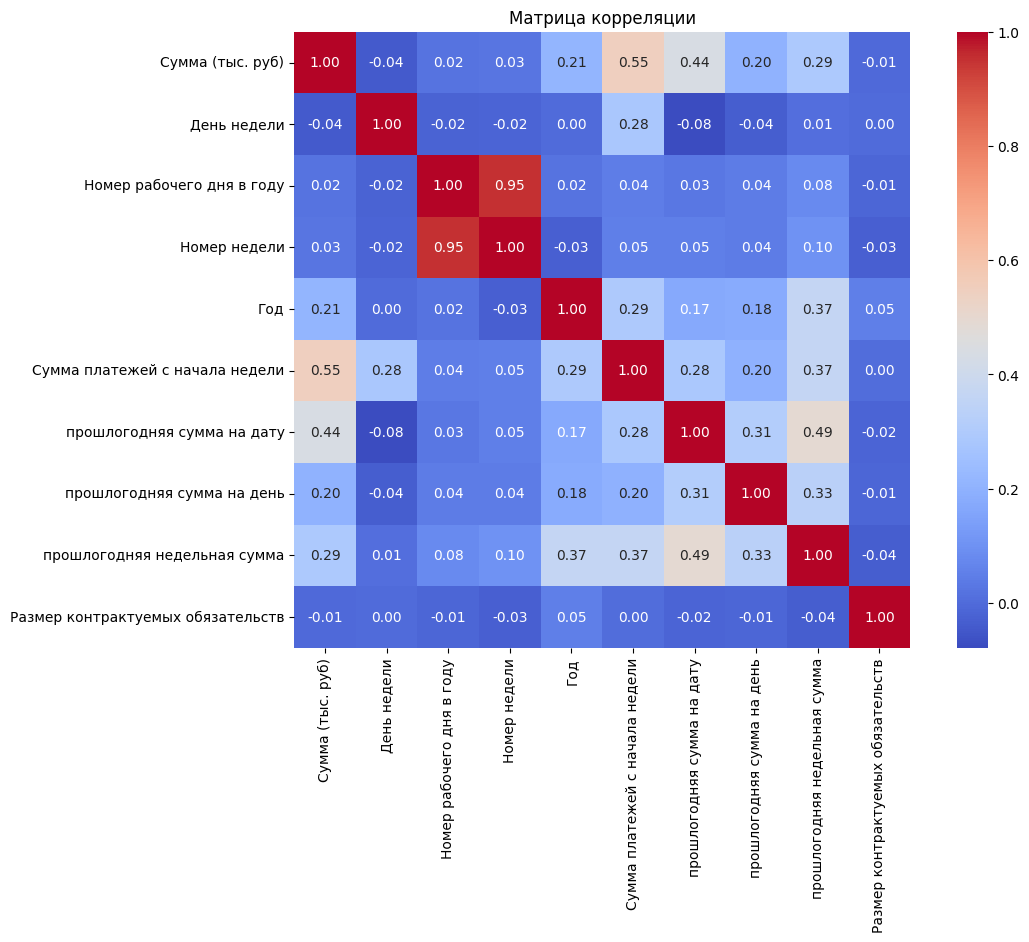

Сумма (тыс. руб)                     1.000000
Сумма платежей с начала недели       0.547276
прошлогодняя сумма на дату           0.439437
прошлогодняя недельная сумма         0.291013
Год                                  0.212083
прошлогодняя сумма на день           0.201397
Номер недели                         0.025844
Номер рабочего дня в году            0.021310
Размер контрактуемых обязательств   -0.005470
День недели                         -0.043456
Name: Сумма (тыс. руб), dtype: float64


In [142]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_df = payments_data_set.drop('Дата оплаты', axis=1)
correlation_matrix = corr_df.corr()
plt.figure(figsize=(12, 8))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)

plt.title('Матрица корреляции')

plt.show()
target_correlation = correlation_matrix['Сумма (тыс. руб)'].sort_values(ascending=False)

print(target_correlation)

In [143]:
earliest_date = payments_data_set['Дата оплаты'].min()
latest_date = payments_data_set['Дата оплаты'].max()

print("Самая ранняя дата оплаты:", earliest_date)
print("Самая поздняя дата оплаты:", latest_date)

Самая ранняя дата оплаты: 2015-11-12 00:00:00
Самая поздняя дата оплаты: 2025-01-10 00:00:00


In [144]:
from datetime import datetime

def get_exchange_rates(start_date, end_date):
    # Форматируем даты в нужный формат
    start_date_str = start_date.strftime('%d/%m/%Y')
    end_date_str = end_date.strftime('%d/%m/%Y')

    # Получаем данные о курсе доллара за указанный период
    url = f'https://cbr.ru/scripts/XML_daily.asp?date_req={end_date_str}'
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Ошибка при получении данных: {response.status_code}")

    # Парсим XML-ответ и получаем курс доллара
    xml_data = response.content
    df = pd.read_xml(xml_data, xpath='//ValCurs/Valute[@ID="R01235"]')
    exchange_rate = df['Value'].iloc[0]

    # Создаём датафрейм с датами и курсом доллара
    date_range = pd.date_range(start=start_date, end=end_date)
    df = pd.DataFrame({'Date': date_range, 'Exchange Rate': exchange_rate})

    return df

In [145]:
usd_df = get_exchange_rates(earliest_date,latest_date)
usd_df.head(15)

ConnectionError: ('Connection aborted.', ConnectionResetError(10054, 'Удаленный хост принудительно разорвал существующее подключение', None, 10054, None))

К сожалению сайт ЦБ РФ не позволяет слишком часто обращаться к нему и разрывает соединение, но данные я выгрузил в несколько итераций

In [151]:
usd_df = pd.read_excel('USD.xlsx')
usd_df['Дата курса'] = pd.to_datetime(usd_df['Дата курса'], format='%d.%m.%Y')
usd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4634 entries, 0 to 4633
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Дата курса  4634 non-null   datetime64[ns]
 1   Валюта      4634 non-null   object        
 2   Курс        4634 non-null   float64       
 3   Кратность   4634 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 144.9+ KB


In [ ]:
payments_data_set = payments_data_set.merge(usd_df[['Дата курса', 'Курс']], 

                             left_on='Дата оплаты', 

                             right_on='Дата курса', 

                             how='left')

payments_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8438 entries, 0 to 8437
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Дата оплаты                        8438 non-null   datetime64[ns]
 1   Сумма (тыс. руб)                   8438 non-null   float64       
 2   День недели                        8438 non-null   int64         
 3   Номер рабочего дня в году          8438 non-null   int64         
 4   Номер недели                       8438 non-null   UInt32        
 5   Год                                8438 non-null   int32         
 6   Сумма платежей с начала недели     8438 non-null   float64       
 7   прошлогодняя сумма на дату         5876 non-null   float64       
 8   прошлогодняя сумма на день         7932 non-null   float64       
 9   прошлогодняя недельная сумма       7958 non-null   float64       
 10  Размер контрактуемых обязательств  8

In [153]:
payments_data_set.drop(columns=['Дата курса'], inplace=True)
payments_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8438 entries, 0 to 8437
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Дата оплаты                        8438 non-null   datetime64[ns]
 1   Сумма (тыс. руб)                   8438 non-null   float64       
 2   День недели                        8438 non-null   int64         
 3   Номер рабочего дня в году          8438 non-null   int64         
 4   Номер недели                       8438 non-null   UInt32        
 5   Год                                8438 non-null   int32         
 6   Сумма платежей с начала недели     8438 non-null   float64       
 7   прошлогодняя сумма на дату         5876 non-null   float64       
 8   прошлогодняя сумма на день         7932 non-null   float64       
 9   прошлогодняя недельная сумма       7958 non-null   float64       
 10  Размер контрактуемых обязательств  8

In [157]:
brent_df = pd.read_excel('нефть-brent.xlsx')
brent_df['Дата'] = pd.to_datetime(brent_df['Дата'], format='%d.%m.%Y')
brent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2737 entries, 0 to 2736
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Дата      2737 non-null   datetime64[ns]
 1   Значение  2737 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 42.9 KB


In [158]:
payments_data_set = payments_data_set.merge(brent_df[['Дата', 'Значение']], 

                             left_on='Дата оплаты', 

                             right_on='Дата', 

                             how='left')

payments_data_set.drop(columns=['Дата'], inplace=True)
payments_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8438 entries, 0 to 8437
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Дата оплаты                        8438 non-null   datetime64[ns]
 1   Сумма (тыс. руб)                   8438 non-null   float64       
 2   День недели                        8438 non-null   int64         
 3   Номер рабочего дня в году          8438 non-null   int64         
 4   Номер недели                       8438 non-null   UInt32        
 5   Год                                8438 non-null   int32         
 6   Сумма платежей с начала недели     8438 non-null   float64       
 7   прошлогодняя сумма на дату         5876 non-null   float64       
 8   прошлогодняя сумма на день         7932 non-null   float64       
 9   прошлогодняя недельная сумма       7958 non-null   float64       
 10  Размер контрактуемых обязательств  8

In [159]:
payments_data_set = payments_data_set.rename(columns={'Курс': 'Курс доллара', 'Значение': 'котировка Brent'})
payments_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8438 entries, 0 to 8437
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Дата оплаты                        8438 non-null   datetime64[ns]
 1   Сумма (тыс. руб)                   8438 non-null   float64       
 2   День недели                        8438 non-null   int64         
 3   Номер рабочего дня в году          8438 non-null   int64         
 4   Номер недели                       8438 non-null   UInt32        
 5   Год                                8438 non-null   int32         
 6   Сумма платежей с начала недели     8438 non-null   float64       
 7   прошлогодняя сумма на дату         5876 non-null   float64       
 8   прошлогодняя сумма на день         7932 non-null   float64       
 9   прошлогодняя недельная сумма       7958 non-null   float64       
 10  Размер контрактуемых обязательств  8

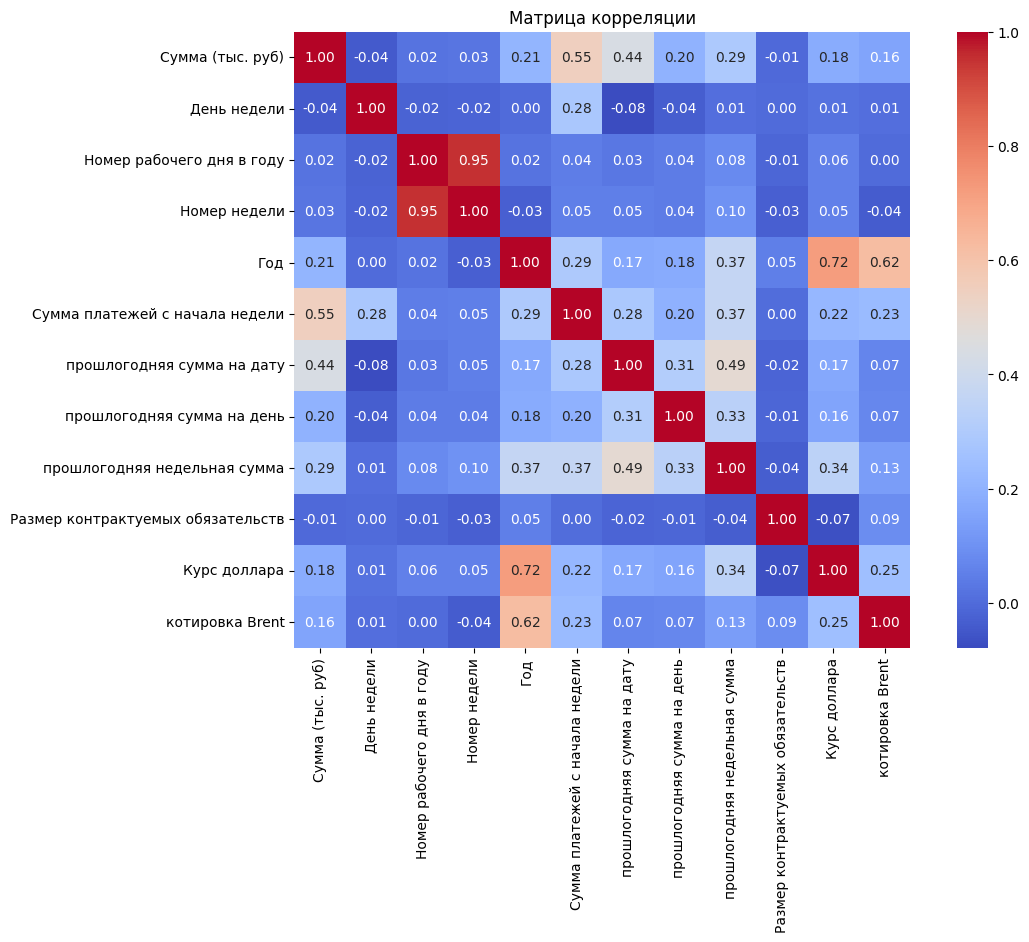

Сумма (тыс. руб)                     1.000000
Сумма платежей с начала недели       0.547276
прошлогодняя сумма на дату           0.439437
прошлогодняя недельная сумма         0.291013
Год                                  0.212083
прошлогодняя сумма на день           0.201397
Курс доллара                         0.181176
котировка Brent                      0.157123
Номер недели                         0.025844
Номер рабочего дня в году            0.021310
Размер контрактуемых обязательств   -0.005470
День недели                         -0.043456
Name: Сумма (тыс. руб), dtype: float64


In [160]:
corr_df = payments_data_set.drop('Дата оплаты', axis=1)
correlation_matrix = corr_df.corr()
plt.figure(figsize=(12, 8))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)

plt.title('Матрица корреляции')

plt.show()
target_correlation = correlation_matrix['Сумма (тыс. руб)'].sort_values(ascending=False)

print(target_correlation)

Датасет готов! Приложение 1 завершено. Сохраняем датасет в файл и переходим к исследованию временного ряда.

In [162]:
#Сохраняем итоговый датасет
payments_data_set.to_excel('payments_data_set.xlsx', index=False, engine='openpyxl')
payments_data_set.to_csv('payments_data_set.csv', index=False, encoding='utf-8')